# DL study second week  
### MNIST dataset으로 MLP (DNN) 모델 구현

In [1]:
# 필요 라이브러리 및 모듈 로드
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
# mnist dataset 불러오기
mnist = tf.keras.datasets.mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
# dataset의 차원 확인하기
print('The dimension of train data :', X_train.shape, y_train.shape)
print('The dimension of test data :', X_test.shape, y_test.shape)

The dimension of train data : (60000, 28, 28) (60000,)
The dimension of test data : (10000, 28, 28) (10000,)


- 위의 출력을 살펴보자  
- train data는 3차원 텐서 (60000, 28, 28), train label data는 벡터 형태 (60000,)의 dimension을 가짐  
- 즉, 28x28 사이즈의 흑백 이미지가 60000장이라는 의미!  
- label은 각 원소가 0~9의 값을 가지는 길이 60000의 벡터라는 의미!  
- test의 경우도 마찬가지  

### One-Hot Encoding이란?  
- 위의 label들을 출력해보면 0~9 사이의 정수 값으로 이루어져 있는 벡터 형태를 가짐  
- loss function을 cross entropy loss를 사용하기 위해서 이들을 원-핫 인코딩을 진행해야 함!    
- 그림으로 살펴보자  
  
<img src = "https://i.ytimg.com/vi/BecEHOVmx9o/maxresdefault.jpg" width=700>  


- 위와 같이 정수를 클래스 갯수 만큼의 n차원 벡터 형태로 바꿔주며 벡터의 원소들은 0 or 1로 구성  
- 또한 1은 무조건 한 개만 존재해야 하며 나머지는 0으로 채워야 함!  
- tensorflow에는 정수 라벨을 원-핫 인코딩 형태로 변환해주는 함수가 존재함!  

In [4]:
# check original samples
print('원-핫 인코딩 변환 전 train label 값:\n', y_train[:3])
print('\n원-핫 인코딩 변환 전 test label 값:\n', y_test[:3])

# one-hot encoding 변환 
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

# check samples after transformation
print('\n원-핫 인코딩 변환 후 train label 값\n', y_train[:3,:])
print('\n원-핫 인코딩 변환 후 test label 값\n', y_test[:3,:])

원-핫 인코딩 변환 전 train label 값:
 [5 0 4]

원-핫 인코딩 변환 전 test label 값:
 [7 2 1]

원-핫 인코딩 변환 후 train label 값
 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

원-핫 인코딩 변환 후 test label 값
 [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


### scaling이란?  
- 이미지에서 각 픽셀은 0~255의 값을 가짐  
- dataset을 255로 나누게 되면 0~1사이의 값을 가지게 됨!  
- 0~1 사이의 값을 가져아 하는 이유는 다음과 같음     
    1. 큰 값을 가지는 변수에 대해서 편향되면 안되기 때문에   
    2. 학습 과정에서 데이터들의 분포가 서로 다르다면 학습에 어려움이 있음    
    
- 또 다른 scaling 방법으로 standard scaling 등이 있으나 neural network에서는 일반적으로 normalization을 수행  
- neural network에서는 input data의 scaling이 필수적!  
- 그러나 label은 스케일링할 필요가 없다는 것을 주의!

In [5]:
print('The maximum value of X_train :', X_train.max(), ', The minimum value of X_train :', X_train.min())
print('The maximum value of X_train :', X_test.max(), ', The minimum value of X_test :', X_test.min())

The maximum value of X_train : 255 , The minimum value of X_train : 0
The maximum value of X_train : 255 , The minimum value of X_test : 0


In [6]:
# normalization
X_train = X_train/255.0
X_test = X_test/255.0

print('The maximum value of X_train :', X_train.max(), ', The minimum value of X_train :', X_train.min())
print('The maximum value of X_train :', X_test.max(), ', The minimum value of X_test :', X_test.min())

The maximum value of X_train : 1.0 , The minimum value of X_train : 0.0
The maximum value of X_train : 1.0 , The minimum value of X_test : 0.0


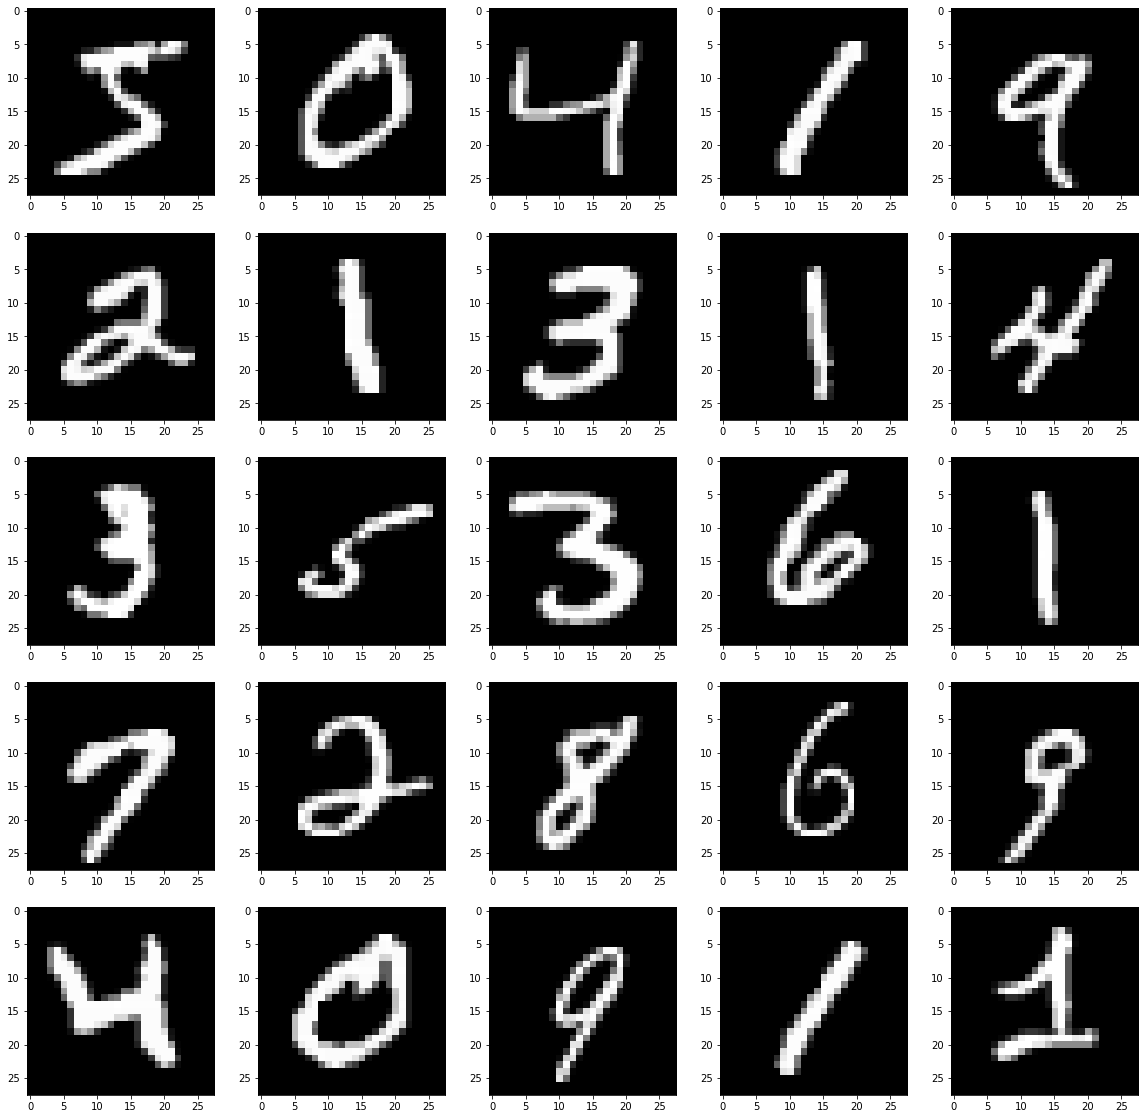

In [7]:
# check sample images
def show_image(nrow, ncol, images):
    plt.figure(figsize=(20,20))
    for i in range(nrow*ncol):
        plt.subplot(nrow, ncol, i+1)
        plt.imshow(images[i], cmap='gray')
    plt.show()
    
show_image(5, 5, X_train)

### image channel이란?  
- MNIST handwritten dataset은 grayscale(흑백) 이미지임  
- 즉, grayscale은 $m\times n\times 1$의 사이즈를 가짐  
- 일반적으로 우리가 가지고 있는 컬러 사진들은 RGB 3 channel을 가짐  
- 즉, RGB는 $m\times n\times 3$의 사이즈를 가짐

### Deep Neural Network Model 구축

#### DNN의 기본 형태
<img src = "https://upload.wikimedia.org/wikipedia/commons/thumb/4/46/Colored_neural_network.svg/800px-Colored_neural_network.svg.png" width=500>  

- 첫 번째 layer를 input layer라고 정의  
- 마지막 layer를 output layer라고 정의  
- 첫 번째, 마지막 layer를 제외한 나머지 layer를 hidden layer라고 정의  
- DNN에서는 첫 번째 layer의 input node 총 갯수는 이미지의 총 픽셀 갯수를 의미  
- 즉, MNIST handwritten dataset 기준으로 $28\times 28 = 784$가 input node 수임
- classification task에서 마지막 layer의 node 수는 분류하고자 하는 클래스 갯수를 넣어야 함  
- 즉, MNIST handwritten dataset 기준으로 0,1,2,...,7,8,9 총 10개 클래스를 넣어야 함  
- 종합적으로 말해, input layer와 output layer의 노드 수는 우리가 수행하고자 하는 task에 맞춰 설정해야함!  
- 이외의 hidden layer의 노드 수나 layer 수는 상관없이 엔지니어 편의에 맞춰 설정  
- 그럼 이 점을 참고하여 모델을 구축해보자  

In [8]:
# DNN model 구축
model = tf.keras.models.Sequential([
    ################# Input Layer #################
    tf.keras.layers.Flatten(input_shape=(28,28)),
    ################# First Hidden Layer #################
    tf.keras.layers.Dense(100, activation='relu'),
    ################# Second hidden layer #################
    tf.keras.layers.Dense(100, activation='relu'),
    ################# Output Layer #################
    tf.keras.layers.Dense(10, activation='softmax')
])

In [9]:
# 모델 구조 살펴보기
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 89,610
Trainable params: 89,610
Non-trainable params: 0
_________________________________________________________________


### activation function이란?  
- activation function은 이전 layer의 output을 다음 layer의 노드로 신호를 전달하는 역할!  
- 만약 activation function이 linear하게 구성된다면? 즉, activation이 없다면?  
    - activation function이 $h\left(x\right)=cx$인 예를 들어보자  
    - 그러면 $y=h\left(h\left(h\left(x\right)\right)\right) = c\times c\times c\times x = c^3x$이다  
    - 즉, $y=ax$에서 $a=c^3$인 선형 함수를 의미!  
    - 이는 hidden layer가 없는 네트워크와 다를 바가 없음!  
    - 그래서 activation function은 nonlinear한 함수로 구성해야 함  
    - 예를 들면 ReLU, sigmoid, tanh 등이 존재  
    - 일반적으로 activation function은 ReLU를 사용함!  
    $$ReLU\,\, function\, : ReLU\left(x\right) = max\left(0, x\right)$$
    - why? 가장 빠른 연산 속도를 가지고 있다는 장점이 있음  
    
- 마지막 layer의 activation function은 무엇을 사용해야 할까?  
    - classification task에서는 일반적으로 output layer의 activation function으로 softmax를 사용!  
    - softmax function의 식을 살펴보자  
    $$softmax\,\, function : f_i\left(x\right) = \frac{\exp\left(x_i\right)}{\sum_j\exp\left(x_j\right)}$$  
    - i 번째 class에서 softmax function에서 나오는 모든 값들의 합은 1이어야 함!  
    - softmax를 사용할 경우 모든 클래스에 대해 0~1 사이의 확률 값을 출력시켜줌!  
    - 즉, 가장 큰 확률의 인덱스가 해당 클래스로 분류 된다는 의미!

In [10]:
# relu 함수 구현
def relu(inputs):
    out = max(0, inputs)
    return out

a = 20
b = -20
print(f'input: {a}, output: {relu(a)}')
print(f'input: {b}, output: {relu(b)}')

input: 20, output: 20
input: -20, output: 0


In [12]:
# softmax 함수에 입력하기 전과 후의 값을 비교해보자
# 아무렇게나 벡터 생성
a = np.array([10,20,30])

# softmax function 구현
def softmax(inputs):
    exp = np.exp(inputs)
    sum_exp = np.sum(exp)
    out = exp/sum_exp
    return out

print('softmax 입력하기 전의 값:', a)
print('softmax 입력한 후의 값:', softmax(a))
print('softmax 출력값을 모두 더하면 1인지 확인:', softmax(a).sum())

softmax 입력하기 전의 값: [10 20 30]
softmax 입력한 후의 값: [2.06106005e-09 4.53978686e-05 9.99954600e-01]
softmax 출력값을 모두 더하면 1인지 확인: 1.0


### 활성화 함수 더 쉽게 이해하기!  
- google에 tensorflow playground 검색  
- 여기에서 다양한 데이터 분포와 다양한 활성화 함수를 적용해 훈련시켜보고   
- 활성화 함수마다 어떤 변화가 생기는지, 어떤 활성화 함수가 더 빠르게 데이터에 피팅하는지 살펴보자  

### loss function, optimizer, learning rate, metrics가 무엇일까?  
- loss function이란?  
    - predicted value와 label의 차이를 구하는 기준  
    - 즉, 딥러닝 모델 학습에 필수!  
    - 손실 함수로는 RMSE, MAE, MSE 등 많은 함수가 존재함  
    - 그러나 위의 손실 함수들은 regression task에 적합한 함수들임  
    - classificaion task에서는 일반적으로 cross entropy loss라는 손실 함수를 사용  
    
- optimizer란?  
    - optimizer는 가장 작은 loss의 값을 얻을 수 있도록 파라미터들을 업데이트 하는 역할을 함!  
    - 즉, predicted가 label과 최대한 비슷하게 출력되도록 해주는 역할임   
    - 이도 딥러닝 모델 학습에 필수임!  
    - optimizer의 종류로 SGD (Stochastic Gradient Descent), momentum, adagrad, RMSProp, Adam 등이 존재  
    
- learning rate란?  
    - optimizer의 최적화 속도에 영향을 미치는 hyperparameter  
    - optimizer에서 learning rate는 gradient에 learning rate를 곱해 다음 지점을 결정하게 됨  
    
<img src = "https://blog.kakaocdn.net/dn/cH1K5u/btrorlNWlbS/bIzqxRHPRo4u4rXh56QGaK/img.png">
    
- metrics이란?  
    - metrics는 model이 train data에 대해 얼마나 잘 피팅되었는지 평가하는 기준  

In [13]:
# 학습하기 전 모델 compile하기
model.compile(optimizer='sgd', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [14]:
# 모델 학습
history = model.fit(X_train, y_train, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 16s 6ms/step - loss: 0.6572 - accuracy: 0.8247
Epoch 2/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.3016 - accuracy: 0.9133
Epoch 3/10
1875/1875 [==============================] - 10s 6ms/step - loss: 0.2485 - accuracy: 0.9291
Epoch 4/10
1875/1875 [==============================] - 10s 6ms/step - loss: 0.2136 - accuracy: 0.9387
Epoch 5/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.1880 - accuracy: 0.9461
Epoch 6/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1681 - accuracy: 0.9519
Epoch 7/10
1875/1875 [==============================] - 12s 7ms/step - loss: 0.1524 - accuracy: 0.9562
Epoch 8/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.1389 - accuracy: 0.9599
Epoch 9/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1274 - accuracy: 0.9631
Epoch 10/10
1875/1875 [==============================] - 11s 6ms/step - lo

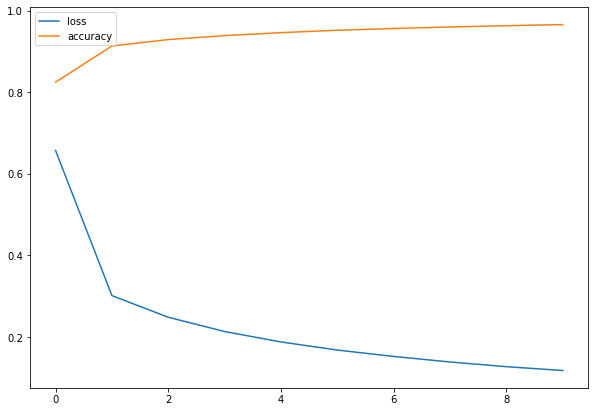

In [15]:
# loss 및 accuracy 그래프 살펴보기
plt.figure(figsize=(10,7))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['accuracy'], label='accuracy')
plt.legend(loc='best')
plt.show()
# loss는 0에 가까울수록 수렴할수록 잘 훈련되었다는 증거!
# accuracy의 경우 1에 가까울수록 잘 훈련되었다는 증거!

In [16]:
# 모델 평가
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'Error: {test_loss}, Accuracy: {test_acc*100}%')

313/313 - 1s - loss: 0.1248 - accuracy: 0.9627 - 512ms/epoch - 2ms/step
Error: 0.12482984364032745, Accuracy: 96.27000093460083%


In [17]:
# test data에 대해 model prediction 진행
prediction = model.predict(X_test)

In [18]:
# one-hot encoding label -> integer label
prediction_label = np.argmax(prediction, axis=1)
test_label = np.argmax(y_test, axis=1)

In [19]:
# prediction_label과 test_label이 같지 않은 인덱스들 뽑기
false_index = np.where(prediction_label!=test_label)[0]

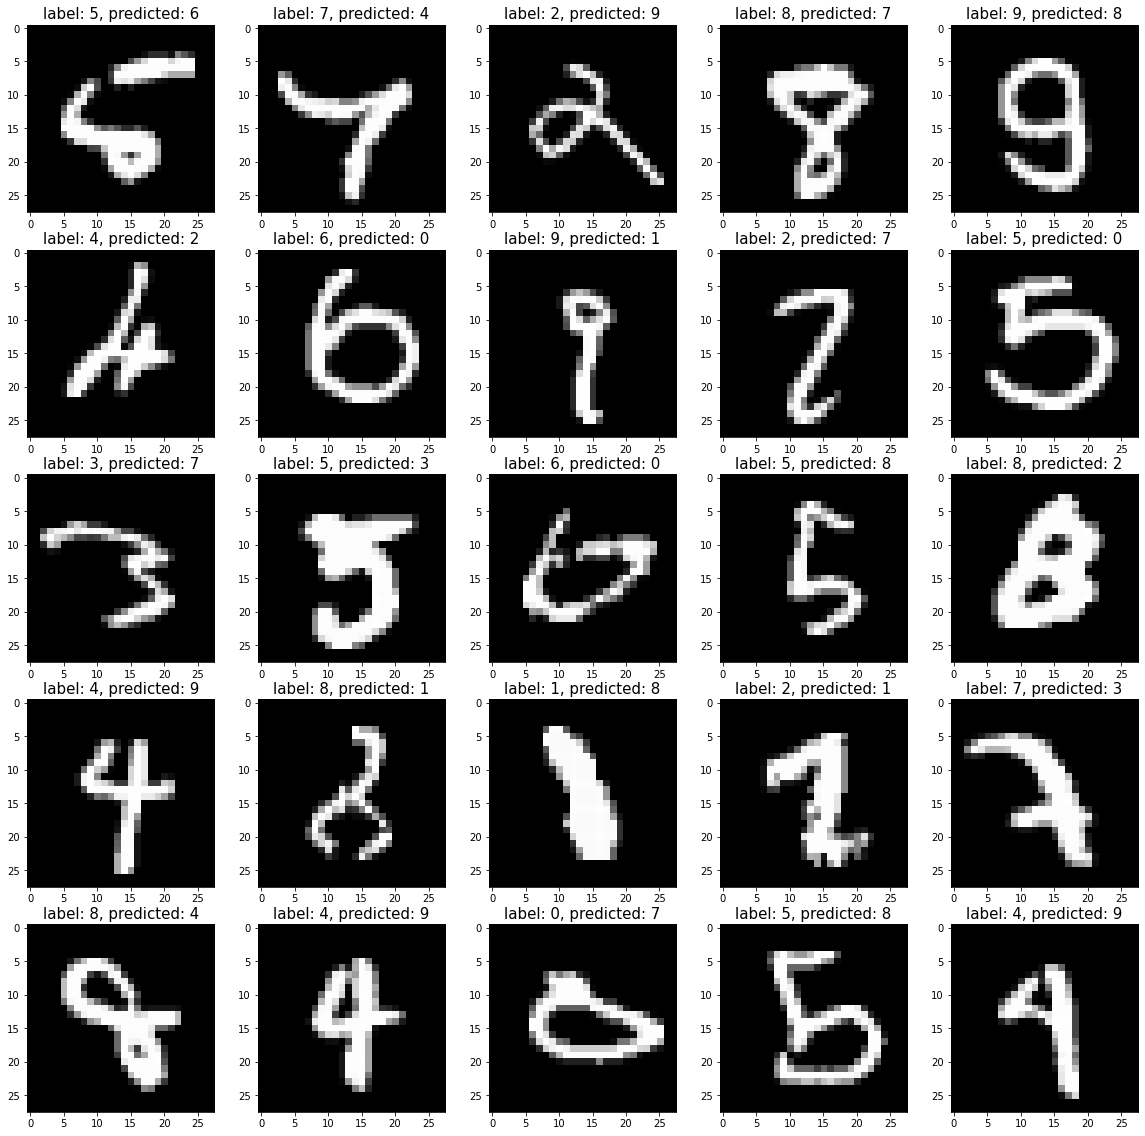

In [20]:
# 잘못 분류된 이미지 살펴보기
plt.figure(figsize=(20,20))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(X_test[false_index[i]], cmap='gray')
    plt.title(f'label: {test_label[false_index[i]]}, predicted: {prediction_label[false_index[i]]}', 
              fontsize=15)
plt.show()

# Homework  
- fashion mnist dataset으로 DNN model 학습시키고 결과 살펴보기  
- 다양한 optimizer와 다양한 learning rate로 model compile한 후 비교해보기 (중요!)  
- DNN model의 hidden layer 수와 노드 수를 다양하게 구성하고 모델 학습하기  
- 다음 스터디까지 CNN(Convolutional Neural Network)에 대해 간단하게 살펴보기